In [12]:
# Importação das bibliotecas para analise de dados
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from prophet import Prophet
from ipywidgets import interact, VBox, HBox
from IPython.display import clear_output
from sklearn.metrics import mean_absolute_error, mean_squared_error
import re

In [13]:
db_vendas = pd.read_csv('historico_vendas.csv')

In [14]:
db_alterado = db_vendas
db_alterado = db_alterado.drop(['ID do Cliente','Coerente','ID do Carro Vendido'], axis=1)

In [15]:
db_alterado.dropna(how='all', inplace=True)

db_alterado.shape

(23007, 15)

In [16]:
# Filter rows with any NaN values
colunas = [
 'Tipo de Cliente',
 'Data da Venda',
 'Marca do Carro',
 'Ano de Fabricação do Carro',
 'Quilometragem do Carro no Momento da Venda',
 'Tipo de Combustível',
 'Tipo de Transmissão',
 'Preço de Venda (R$)',
 'Forma de Pagamento',
 'Status do Pagamento',
 'Histórico de Aluguel (se aplicável)',
 'ID do Contrato de Aluguel Anterior (se aplicável)',
 'Desconto para Ex-cliente de Aluguel (%)',
 'Cancelamento da Venda',
 'Motivo do Cancelamento (se aplicável)'
 ]
i = 0
for coluna in colunas:
    i+=1
    if db_alterado[coluna].isna().any() == True:
        print(f"{True}" + " " + "na coluna" + " " + coluna)
    
print(i,len(db_alterado.shape))

db_vendas.shape

True na coluna ID do Contrato de Aluguel Anterior (se aplicável)
True na coluna Motivo do Cancelamento (se aplicável)
15 2


(23027, 18)

In [17]:
db_alterado = db_alterado.drop_duplicates()

db_alterado.shape

(23007, 15)

In [18]:
db_alterado['Tipo de Cliente'] = db_alterado['Tipo de Cliente'].str.lower().str.strip()

In [19]:
db_alterado['Data da Venda'].dtype #ou seja eh uma string 

data_venda = db_alterado['Data da Venda']


def convert_to_month_year(date_str):
    if isinstance(date_str, str):
        # First, check if the date is already in the yyyy-mm-dd format
        if re.match(r'\d{4}-\d{2}-\d{2}', date_str):
            return pd.to_datetime(date_str).strftime('%Y-%m')  # Convert and format as Year-Month
        
        # Check for the dd/mm/yyyy format
        elif re.match(r'\d{2}/\d{2}/\d{4}', date_str):
            return pd.to_datetime(date_str, dayfirst=True).strftime('%Y-%m')  # Convert and format as Year-Month
        
        # Handle verbose format like '03 de August de 2023'
        match = re.match(r'(\d{1,2}) de (\w+) de (\d{4})', date_str)
        if match:
            day, month, year = match.groups()
            # Mapping Portuguese/English month names to their corresponding numbers
            months_mapping = {
                'january': '01', 'february': '02', 'march': '03', 'april': '04', 'may': '05',
                'june': '06', 'july': '07', 'august': '08', 'september': '09', 'october': '10',
                'november': '11', 'december': '12',
                'janeiro': '01', 'fevereiro': '02', 'março': '03', 'abril': '04', 'maio': '05',
                'junho': '06', 'julho': '07', 'agosto': '08', 'setembro': '09', 'outubro': '10',
                'novembro': '11', 'dezembro': '12'
            }
            month_num = months_mapping.get(month.lower(), None)
            if month_num:
                # Return in Year-Month format
                return f'{year}-{month_num}'


db_alterado['Data da Venda'] = data_venda.apply(convert_to_month_year)

"""for i in range(0,len(data_venda),15):
    display(data_venda[i:i+15])
"""


'for i in range(0,len(data_venda),15):\n    display(data_venda[i:i+15])\n'

In [20]:
db_alterado['Ano de Fabricação do Carro'] = db_alterado['Ano de Fabricação do Carro'].astype(int)

In [21]:
db_alterado = db_alterado.applymap(lambda x: x.strip().lower() if isinstance(x, str) else x)

db_alterado = db_alterado.applymap(lambda x: x.strip().strip() if isinstance(x, str) else x)

In [22]:
db_alterado["Cancelamento da Venda"].isna().any()

False

In [23]:
# Correctly filter rows where 'Cancelamento da Venda' is 'sim'
db_alterado["Cancelamento da Venda"] = db_alterado.loc[db_alterado["Cancelamento da Venda"] != "sim", "Cancelamento da Venda"]

db_alterado.dropna(subset=["Cancelamento da Venda"], inplace=True)


display(db_alterado['Cancelamento da Venda'])

db_alterado.shape

0        não
1        não
3        não
4        não
9        não
        ... 
23014    não
23017    não
23020    não
23025    nao
23026    não
Name: Cancelamento da Venda, Length: 11533, dtype: object

(11533, 15)

In [24]:

db_alterado['Tipo de Combustível'] = db_alterado['Tipo de Combustível'].replace({
    'elétrico': 'eletrico',
    'híbrido': 'hibrido'
})

db_alterado['Forma de Pagamento'] = db_alterado['Forma de Pagamento'].replace({
    'cartao de crédito': 'cartao de credito',
    'cartão de credito': 'cartao de credito',
    'cartão de crédito': 'cartao de credito',
    'transferência bancária' : 'transferencia bancaria'
})

db_alterado['Histórico de Aluguel (se aplicável)'] = db_alterado['Histórico de Aluguel (se aplicável)'].replace({
    'n': 'nao',
    'não': 'nao'
})

db_alterado['Cancelamento da Venda'] = db_alterado['Cancelamento da Venda'].replace({
    'n': 'nao',
    'não':'nao'
})



In [25]:
# Check the structure of the dataset
db_alterado.info()

# Check for missing values
db_alterado.isna().sum()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 11533 entries, 0 to 23026
Data columns (total 15 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   Tipo de Cliente                                    11533 non-null  object 
 1   Data da Venda                                      11533 non-null  object 
 2   Marca do Carro                                     11533 non-null  object 
 3   Ano de Fabricação do Carro                         11533 non-null  int64  
 4   Quilometragem do Carro no Momento da Venda         11533 non-null  float64
 5   Tipo de Combustível                                11533 non-null  object 
 6   Tipo de Transmissão                                11533 non-null  object 
 7   Preço de Venda (R$)                                11533 non-null  float64
 8   Forma de Pagamento                                 11533 non-null  object 
 9   Status

Tipo de Cliente                                          0
Data da Venda                                            0
Marca do Carro                                           0
Ano de Fabricação do Carro                               0
Quilometragem do Carro no Momento da Venda               0
Tipo de Combustível                                      0
Tipo de Transmissão                                      0
Preço de Venda (R$)                                      0
Forma de Pagamento                                       0
Status do Pagamento                                      0
Histórico de Aluguel (se aplicável)                      0
ID do Contrato de Aluguel Anterior (se aplicável)     8699
Desconto para Ex-cliente de Aluguel (%)                  0
Cancelamento da Venda                                    0
Motivo do Cancelamento (se aplicável)                11533
dtype: int64

16:12:21 - cmdstanpy - INFO - Chain [1] start processing
16:12:21 - cmdstanpy - INFO - Chain [1] done processing


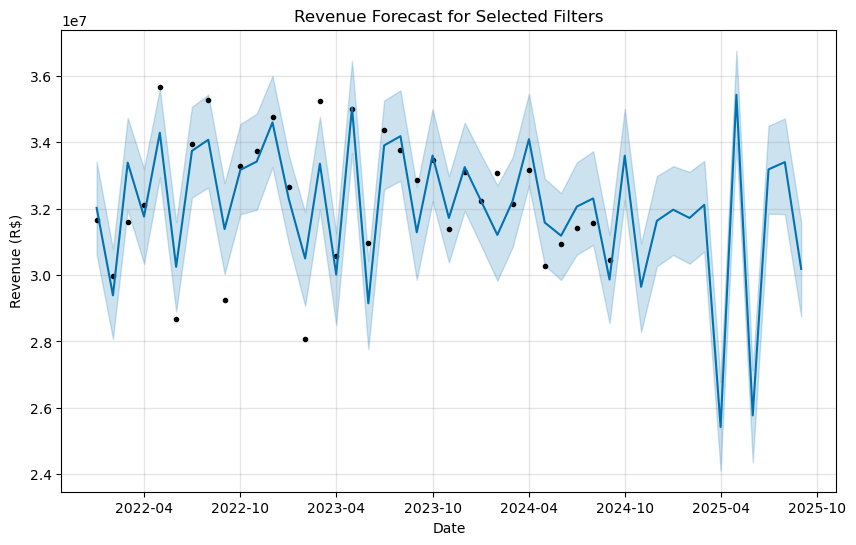

In [26]:

# Step 1: Ensure 'Data da Venda' is in datetime format
db_forecast = db_alterado.copy()  # Use your already filtered db_alterado for vendas
db_forecast['Data da Venda'] = pd.to_datetime(db_forecast['Data da Venda'], errors='coerce')  # Convert to datetime

# Check if there are any rows where the conversion failed (invalid dates)
invalid_dates = db_forecast['Data da Venda'].isna().sum()
if invalid_dates > 0:
    print(f"Warning: {invalid_dates} rows have invalid dates and were set to NaT.")

# Step 2: Extract month and year from 'Data da Venda'
db_forecast['Mes'] = db_forecast['Data da Venda'].dt.month
db_forecast['Ano'] = db_forecast['Data da Venda'].dt.year

# Step 3: Filter out sales with pending payments
db_forecast_filtered = db_forecast[db_forecast['Status do Pagamento'] != 'pendente']

# Step 3: Create the checkboxes for each value in a category

# Function to create checkboxes for a column's unique values
def create_checkboxes(options, description):
    checkboxes = [widgets.Checkbox(value=True, description=str(option)) for option in options]
    return widgets.VBox([widgets.Label(value=description)] + checkboxes)

# Create checkboxes for each category
tipo_cliente_checkboxes = create_checkboxes(db_forecast['Tipo de Cliente'].unique(), 'Tipo de Cliente')
combustivel_checkboxes = create_checkboxes(db_forecast['Tipo de Combustível'].unique(), 'Combustível')
marca_carro_checkboxes = create_checkboxes(db_forecast['Marca do Carro'].unique(), 'Marca do Carro')
transmissao_checkboxes = create_checkboxes(db_forecast['Tipo de Transmissão'].unique(), 'Transmissão')

# Step 4: Define a helper function to get selected checkboxes
def get_selected_options(checkboxes):
    selected = [box.description for box in checkboxes.children[1:] if box.value]
    return selected

# Step 5: Define the function that will filter the data and make predictions
def forecast_revenue():
    # Clear the previous output (to update the same plot instead of creating new ones)
    clear_output(wait=True)
    
    # Step 5.1: Get the selected options from each category
    tipo_cliente = get_selected_options(tipo_cliente_checkboxes)
    combustivel = get_selected_options(combustivel_checkboxes)
    marca_carro = get_selected_options(marca_carro_checkboxes)
    transmissao = get_selected_options(transmissao_checkboxes)
    
    # Step 5.2: Filter the dataset based on the user's selections
    filtered_data = db_forecast_filtered[
        (db_forecast_filtered['Tipo de Cliente'].isin(tipo_cliente)) &
        (db_forecast_filtered['Tipo de Combustível'].isin(combustivel)) &
        (db_forecast_filtered['Marca do Carro'].isin(marca_carro)) &
        (db_forecast_filtered['Tipo de Transmissão'].isin(transmissao))
    ]
    
    # Step 5.3: Aggregate revenue by month (sum the 'Valor do contrato do aluguel')
    monthly_revenue_forescast = filtered_data.groupby(['Ano', 'Mes'])['Preço de Venda (R$)'].sum().reset_index(name='Revenue')
    
    # Ensure there's enough data
    if len(monthly_revenue_forescast) < 5:
        print("Not enough data for the selected filters.")
        return
    
    # Step 5.4: Prepare the data for Prophet
    monthly_revenue_forescast['ds'] = pd.to_datetime(monthly_revenue_forescast['Ano'].astype(str) + '-' + monthly_revenue_forescast['Mes'].astype(str) + '-01')
    monthly_revenue_forescast['y'] = monthly_revenue_forescast['Revenue']
    
    # Step 5.5: Train Prophet model on filtered data
    model = Prophet()
    model.fit(monthly_revenue_forescast[['ds', 'y']])
    
    # Step 5.6: Forecast the next 12 months
    future = model.make_future_dataframe(periods=16, freq='M')
    forecast = model.predict(future)
    
    # Step 5.7: Plot the forecast
    fig, ax = plt.subplots(figsize=(10, 6))
    model.plot(forecast, ax=ax)
    plt.title(f'Revenue Forecast for Selected Filters')
    plt.xlabel('Date')
    plt.ylabel('Revenue (R$)')
    plt.show()

    # Re-display the interface to keep the widgets and button visible
    display(VBox([
        HBox([tipo_cliente_checkboxes, transmissao_checkboxes]),  # Horizontal layout for better clarity
        HBox([combustivel_checkboxes, marca_carro_checkboxes]),
        forecast_button
    ]))

# Step 6: Create a button to trigger the forecast and layout the interface
forecast_button = widgets.Button(description="Generate Revenue Forecast")
forecast_button.on_click(lambda x: forecast_revenue())

# Step 7: Display the interface with checkboxes and the button
display(VBox([
    HBox([tipo_cliente_checkboxes, transmissao_checkboxes]),  # Horizontal layout for better clarity
    HBox([combustivel_checkboxes, marca_carro_checkboxes]),
    forecast_button
]))


22:06:57 - cmdstanpy - INFO - Chain [1] start processing
22:06:58 - cmdstanpy - INFO - Chain [1] done processing


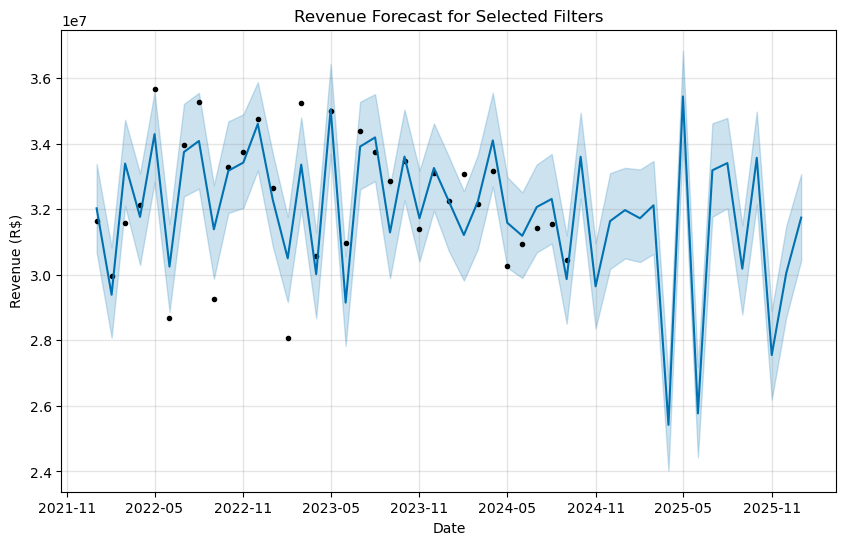

In [35]:

# Step 1: Ensure 'Data da Venda' is in datetime format
db_forecast_total = db_alterado.copy()  # Use your already filtered db_alterado for vendas
db_forecast_total['Data da Venda'] = pd.to_datetime(db_forecast_total['Data da Venda'], errors='coerce')  # Convert to datetime

# Check if there are any rows where the conversion failed (invalid dates)
invalid_dates = db_forecast_total['Data da Venda'].isna().sum()
if invalid_dates > 0:
    print(f"Warning: {invalid_dates} rows have invalid dates and were set to NaT.")

# Step 2: Extract month and year from 'Data da Venda'
db_forecast_total['Mes'] = db_forecast_total['Data da Venda'].dt.month
db_forecast_total['Ano'] = db_forecast_total['Data da Venda'].dt.year

# Step 3: Filter out sales with pending payments
db_forecast_filtered_total = db_forecast_total[db_forecast_total['Status do Pagamento'] != 'pendente']

# Step 5.3: Aggregate revenue by month (sum the 'Valor do contrato do aluguel')
monthly_revenue_forescast = db_forecast_filtered_total.groupby(['Ano', 'Mes'])['Preço de Venda (R$)'].sum().reset_index(name='Revenue')

# Step 5.4: Prepare the data for Prophet
monthly_revenue_forescast['ds'] = pd.to_datetime(monthly_revenue_forescast['Ano'].astype(str) + '-' + monthly_revenue_forescast['Mes'].astype(str) + '-01')
monthly_revenue_forescast['y'] = monthly_revenue_forescast['Revenue']

# Step 5.5: Train Prophet model on filtered data
model = Prophet()
model.fit(monthly_revenue_forescast[['ds', 'y']])

# Step 5.6: Forecast the next 12 months
future = model.make_future_dataframe(periods=16, freq='M')
forecast = model.predict(future)

# Step 5.7: Plot the forecast
fig, ax = plt.subplots(figsize=(10, 6))
model.plot(forecast, ax=ax)
plt.title(f'Revenue Forecast for Selected Filters')
plt.xlabel('Date')
plt.ylabel('Revenue (R$)')
plt.show()

forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].to_excel('previsao_faturamento2.xlsx', index=False)



20:04:40 - cmdstanpy - INFO - Chain [1] start processing
20:04:40 - cmdstanpy - INFO - Chain [1] done processing


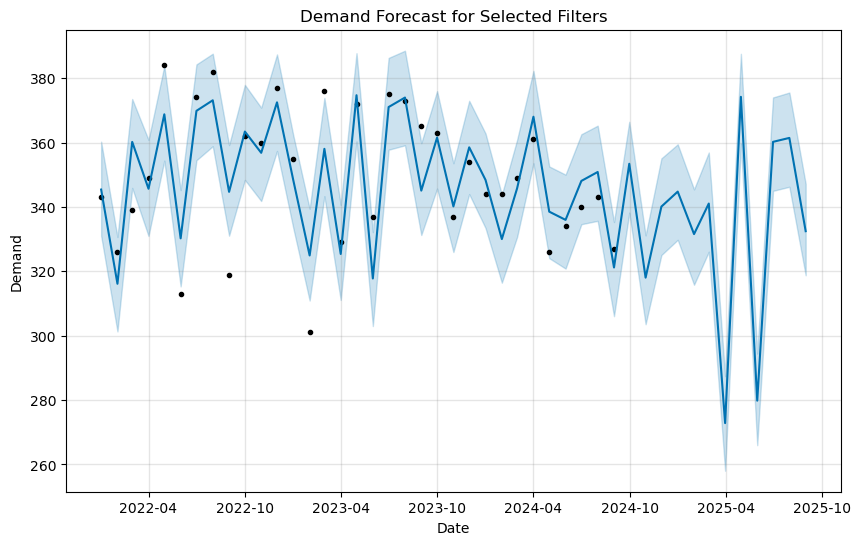

In [33]:
# Demanda

# Step 1: Ensure 'Data da Venda' is in datetime format
db_demand = db_alterado.copy()  # Use your already filtered db_alterado for vendas
db_demand['Data da Venda'] = pd.to_datetime(db_demand['Data da Venda'], errors='coerce')  # Convert to datetime

# Check if there are any rows where the conversion failed (invalid dates)
invalid_dates = db_demand['Data da Venda'].isna().sum()
if invalid_dates > 0:
    print(f"Warning: {invalid_dates} rows have invalid dates and were set to NaT.")

# Step 2: Extract month and year from 'Data da Venda'
db_demand['Mes'] = db_demand['Data da Venda'].dt.month
db_demand['Ano'] = db_demand['Data da Venda'].dt.year

# Step 3: Filter out sales with pending payments
db_demand_filtered = db_demand[db_demand['Status do Pagamento'] != 'pendente']

# Step 3: Create the checkboxes for each value in a category

# Function to create checkboxes for a column's unique values
def create_checkboxes(options, description):
    checkboxes = [widgets.Checkbox(value=True, description=str(option)) for option in options]
    return widgets.VBox([widgets.Label(value=description)] + checkboxes)

# Create checkboxes for each category
tipo_cliente_checkboxes = create_checkboxes(db_demand['Tipo de Cliente'].unique(), 'Tipo de Cliente')
combustivel_checkboxes = create_checkboxes(db_demand['Tipo de Combustível'].unique(), 'Combustível')
marca_carro_checkboxes = create_checkboxes(db_demand['Marca do Carro'].unique(), 'Marca do Carro')
transmissao_checkboxes = create_checkboxes(db_demand['Tipo de Transmissão'].unique(), 'Transmissão')

# Step 4: Define a helper function to get selected checkboxes
def get_selected_options(checkboxes):
    selected = [box.description for box in checkboxes.children[1:] if box.value]
    return selected

# Step 5: Define the function that will filter the data and make predictions
def forecast_Demand():
    # Clear the previous output (to update the same plot instead of creating new ones)
    clear_output(wait=True)
    
    # Step 5.1: Get the selected options from each category
    tipo_cliente = get_selected_options(tipo_cliente_checkboxes)
    combustivel = get_selected_options(combustivel_checkboxes)
    marca_carro = get_selected_options(marca_carro_checkboxes)
    transmissao = get_selected_options(transmissao_checkboxes)
    
    # Step 5.2: Filter the dataset based on the user's selections
    filtered_data = db_demand_filtered[
        (db_demand_filtered['Tipo de Cliente'].isin(tipo_cliente)) &
        (db_demand_filtered['Tipo de Combustível'].isin(combustivel)) &
        (db_demand_filtered['Marca do Carro'].isin(marca_carro)) &
        (db_demand_filtered['Tipo de Transmissão'].isin(transmissao))
    ]
    
    # Step 5.3: Aggregate revenue by month (sum the 'Valor do contrato do aluguel')
    monthly_demand_forescast = filtered_data.groupby(['Ano', 'Mes']).size().reset_index(name='Demand')
    
    # Ensure there's enough data
    if len(monthly_demand_forescast) < 5:
        print("Not enough data for the selected filters.")
        return
    
    # Step 5.4: Prepare the data for Prophet
    monthly_demand_forescast['ds'] = pd.to_datetime(monthly_demand_forescast['Ano'].astype(str) + '-' + monthly_demand_forescast['Mes'].astype(str) + '-01')
    monthly_demand_forescast['y'] = monthly_demand_forescast['Demand']
    
    # Step 5.5: Train Prophet model on filtered data
    model = Prophet()
    model.fit(monthly_demand_forescast[['ds', 'y']])
    
    # Step 5.6: Forecast the next 12 months
    future = model.make_future_dataframe(periods=16, freq='M')
    forecast = model.predict(future)
    
    # Step 5.7: Plot the forecast
    fig, ax = plt.subplots(figsize=(10, 6))
    model.plot(forecast, ax=ax)
    plt.title(f'Demand Forecast for Selected Filters')
    plt.xlabel('Date')
    plt.ylabel('Demand')
    plt.show()

    # Re-display the interface to keep the widgets and button visible
    display(VBox([
        HBox([tipo_cliente_checkboxes, transmissao_checkboxes]),  # Horizontal layout for better clarity
        HBox([combustivel_checkboxes, marca_carro_checkboxes]),
        forecast_button
    ]))

# Step 6: Create a button to trigger the forecast and layout the interface
forecast_button = widgets.Button(description="Generate Demand Forecast")
forecast_button.on_click(lambda x: forecast_Demand())

# Step 7: Display the interface with checkboxes and the button
display(VBox([
    HBox([tipo_cliente_checkboxes, transmissao_checkboxes]),  # Horizontal layout for better clarity
    HBox([combustivel_checkboxes, marca_carro_checkboxes]),
    forecast_button
]))


22:07:26 - cmdstanpy - INFO - Chain [1] start processing
22:07:26 - cmdstanpy - INFO - Chain [1] done processing


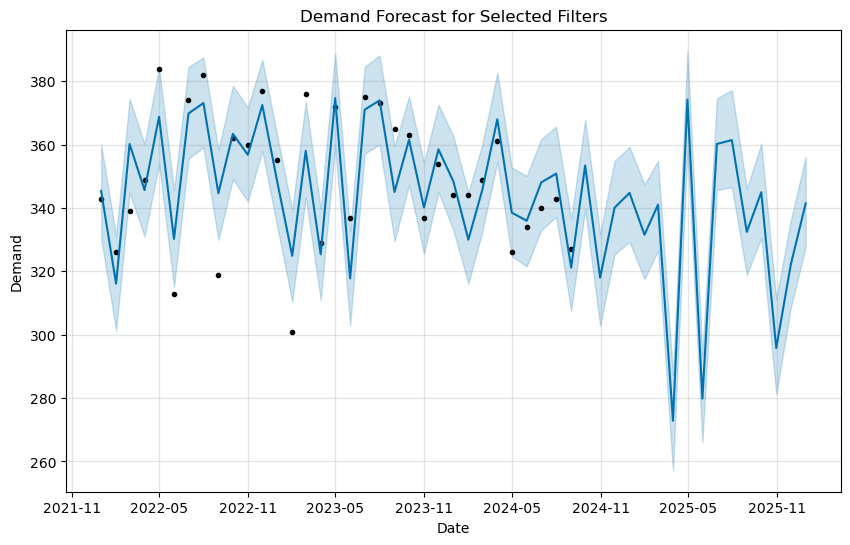

In [36]:
# Demanda

# Step 1: Ensure 'Data da Venda' is in datetime format
db_demand_total = db_alterado.copy()  # Use your already filtered db_alterado for vendas
db_demand_total['Data da Venda'] = pd.to_datetime(db_demand_total['Data da Venda'], errors='coerce')  # Convert to datetime

# Check if there are any rows where the conversion failed (invalid dates)
invalid_dates = db_demand_total['Data da Venda'].isna().sum()
if invalid_dates > 0:
    print(f"Warning: {invalid_dates} rows have invalid dates and were set to NaT.")

# Step 2: Extract month and year from 'Data da Venda'
db_demand_total['Mes'] = db_demand_total['Data da Venda'].dt.month
db_demand_total['Ano'] = db_demand_total['Data da Venda'].dt.year

# Step 3: Filter out sales with pending payments
db_demand_filtered_total = db_demand_total[db_demand_total['Status do Pagamento'] != 'pendente']
    
# Step 5.3: Aggregate revenue by month (sum the 'Valor do contrato do aluguel')
monthly_demand_forescast = db_demand_filtered_total.groupby(['Ano', 'Mes']).size().reset_index(name='Demand')

# Step 5.4: Prepare the data for Prophet
monthly_demand_forescast['ds'] = pd.to_datetime(monthly_demand_forescast['Ano'].astype(str) + '-' + monthly_demand_forescast['Mes'].astype(str) + '-01')
monthly_demand_forescast['y'] = monthly_demand_forescast['Demand']

# Step 5.5: Train Prophet model on filtered data
model = Prophet()
model.fit(monthly_demand_forescast[['ds', 'y']])

# Step 5.6: Forecast the next 12 months
future = model.make_future_dataframe(periods=16, freq='M')
forecast = model.predict(future)

# Step 5.7: Plot the forecast
fig, ax = plt.subplots(figsize=(10, 6))
model.plot(forecast, ax=ax)
plt.title(f'Demand Forecast for Selected Filters')
plt.xlabel('Date')
plt.ylabel('Demand')
plt.show()

forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].to_excel('previsao_demanda.xlsx', index=False)
